In [51]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.io import arff

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [52]:
data = arff.loadarff('electricity-normalized.arff')
df = pd.DataFrame(data[0])
df.head(20)

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class
0,0.0,b'2',0.000000,0.056443,0.439155,0.003467,0.422915,0.414912,b'UP'
1,0.0,b'2',0.021277,0.051699,0.415055,0.003467,0.422915,0.414912,b'UP'
2,0.0,b'2',0.042553,0.051489,0.385004,0.003467,0.422915,0.414912,b'UP'
3,0.0,b'2',0.063830,0.045485,0.314639,0.003467,0.422915,0.414912,b'UP'
4,0.0,b'2',0.085106,0.042482,0.251116,0.003467,0.422915,0.414912,b'DOWN'
5,0.0,b'2',0.106383,0.041161,0.207528,0.003467,0.422915,0.414912,b'DOWN'
6,0.0,b'2',0.127660,0.041161,0.171824,0.003467,0.422915,0.414912,b'DOWN'
7,0.0,b'2',0.148936,0.041161,0.152782,0.003467,0.422915,0.414912,b'DOWN'
8,0.0,b'2',0.170213,0.041161,0.134930,0.003467,0.422915,0.414912,b'DOWN'
9,0.0,b'2',0.191489,0.041161,0.140583,0.003467,0.422915,0.414912,b'DOWN'


<Axes: xlabel='class', ylabel='count'>

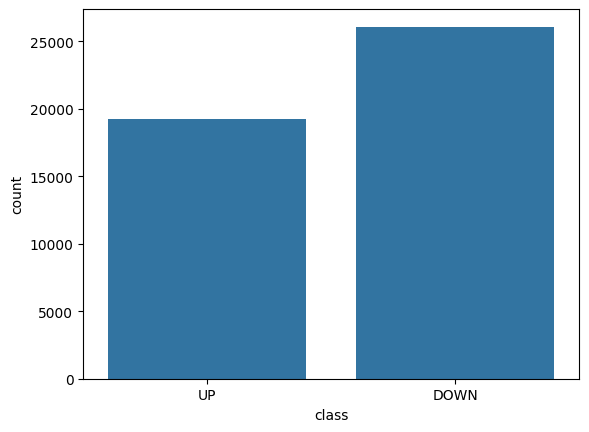

In [53]:
sns.countplot(x = 'class', data=df)

In [54]:
df['class'] = df['class'].astype('category')
encode_map = {
    b'UP': 1,
    b'DOWN': 0
}

df['class'].replace(encode_map, inplace=True)

In [55]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=69)

In [57]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [58]:
EPOCHS = 200
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [59]:
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = TrainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train))

In [60]:
class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = TestData(torch.FloatTensor(X_test))

In [61]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

In [62]:
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [63]:
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        self.layer_1 = nn.Linear(8, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_3 = nn.Linear(64, 64)
        self.layer_4 = nn.Linear(64, 8)
        self.layer_out = nn.Linear(8, 1)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.relu(self.layer_3(x))
        x = self.batchnorm3(x)
        x = self.relu(self.layer_4(x))
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [64]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [65]:
model = BinaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

BinaryClassification(
  (layer_1): Linear(in_features=8, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_3): Linear(in_features=64, out_features=64, bias=True)
  (layer_4): Linear(in_features=64, out_features=8, bias=True)
  (layer_out): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [66]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [67]:
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.48864 | Acc: 76.314
Epoch 002: | Loss: 0.45601 | Acc: 78.731
Epoch 003: | Loss: 0.44836 | Acc: 79.192
Epoch 004: | Loss: 0.44014 | Acc: 79.495
Epoch 005: | Loss: 0.43597 | Acc: 79.785
Epoch 006: | Loss: 0.43354 | Acc: 79.855
Epoch 007: | Loss: 0.42591 | Acc: 80.381
Epoch 008: | Loss: 0.42284 | Acc: 80.667
Epoch 009: | Loss: 0.42097 | Acc: 80.518
Epoch 010: | Loss: 0.41510 | Acc: 80.943
Epoch 011: | Loss: 0.41292 | Acc: 81.156
Epoch 012: | Loss: 0.40981 | Acc: 81.242
Epoch 013: | Loss: 0.40926 | Acc: 81.211
Epoch 014: | Loss: 0.40753 | Acc: 81.524
Epoch 015: | Loss: 0.40245 | Acc: 81.594
Epoch 016: | Loss: 0.39968 | Acc: 81.642
Epoch 017: | Loss: 0.39853 | Acc: 81.928
Epoch 018: | Loss: 0.39822 | Acc: 81.924
Epoch 019: | Loss: 0.39636 | Acc: 81.880
Epoch 020: | Loss: 0.39234 | Acc: 81.872
Epoch 021: | Loss: 0.39220 | Acc: 82.017
Epoch 022: | Loss: 0.38905 | Acc: 82.118
Epoch 023: | Loss: 0.38550 | Acc: 82.402
Epoch 024: | Loss: 0.38801 | Acc: 82.051
Epoch 025: | Los

In [68]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [69]:
confusion_matrix(y_test, y_pred_list)

array([[7698,  920],
       [1417, 4918]])

In [70]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.84      0.89      0.87      8618
           1       0.84      0.78      0.81      6335

    accuracy                           0.84     14953
   macro avg       0.84      0.83      0.84     14953
weighted avg       0.84      0.84      0.84     14953

